In [1]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('final_csv_task1.csv', usecols=['comp_date',
                                                 'product_id',
                                                 'seller_id',
                                                 'min',
                                                 'price',
                                                 'max' ,
                                                 'difference'])

enc = LabelEncoder()
df['enc_comp_date'] = enc.fit_transform(df['comp_date'])

df["comp_date"] =  pd.to_datetime(df["comp_date"], format = "%Y/%m/%d")
df["quarter"] = df.comp_date.dt.quarter

In [ ]:
# Detect the relationship between each seller's price for a given product every day, and the max price of the other's sellers.
# The higher the difference, the bigger the chance to get an A -> "LEADER"
# More A you have, the bigger the change to be considered a leader or a seller which has a max price strategy

def leader_detection(product_id, quarter):

    # Filter the dataset
    df_1 = df[(df.product_id == product_id) & (df.quarter == quarter)]

    # Dataviz
    plt.figure(figsize=(10, 5), dpi = 300)
    sns.set_style("whitegrid")
    sns.lineplot(df_1, x = 'comp_date',y = 'price', hue = 'seller_id', palette = 'deep')\
                    .set(title='Price variation for product {} in Q{}'.format(product_id, quarter))

    dataf = pd.DataFrame()

    windows = {1: 'daily'
#               , 2: 'bidaily'
#               , 3: 'tridaily'
#               , 7: 'weekly'
#               , 15: 'biweekly'
#               , 30: 'monthly'
               }

    # For each day:
    for day in df_1['enc_comp_date'].unique():

        # Make a copy and filter by day
        df_2 = df_1.copy(deep = True)
        df_2 = df_2[df_2['enc_comp_date'] == day]

        # For each seller
        for seller in df_2['seller_id'].unique():

            # Extract the price for a given seller and a giver day
            price = df_2.loc[df['seller_id'] == seller, 'price'].iloc[0]

            # Take the max price excluded itself
            price_others_max = df_2.loc[df['seller_id'] != seller, 'price'].max()

            # Calculate the difference between prices
            difference = (price - price_others_max) / price * 100

            # Create a list with the day, seller and difference
            lst = [day, seller, difference]

            dataf = pd.concat([dataf, pd.DataFrame([lst])])

    dataf.rename(columns = {0: 'day', 1: 'seller', 2: 'difference'}, inplace = True)

    # For each window size, cut the dataset every day, every two days, every week etc...
    dfs = []
    for window in windows:
      L = [g for k, g in dataf.groupby('day')]
      dfs.extend([pd.concat(L[i:i+window]) for i in range(0, len(L)-window+1)])

    # Calculate the label on each dataset which are cut: A = leader, B = competitor, C = loser
    for i in range(len(dfs)):
        dfs[i]['label'] = pd.cut(dfs[i]['difference'], 3, labels = ['C', 'B', 'A'])

    # Create a dataframe which contains the occurrences of all the dataset created above, per seller, per label ABC
    data_frame = pd.DataFrame()
    for i in range(len(dfs)):
        data_frame = pd.concat([data_frame, dfs[i].drop(['day', 'difference'], axis = 1)])

    data_frame = data_frame.groupby(by = ['seller', 'label']).size().reset_index()
    data_frame.rename(columns = {0 : 'count'}, inplace = True)

    # Plot the distribution
    plt.figure(figsize=(10, 5), dpi = 300)
    sns.set_style("whitegrid")
    sns.barplot(data = data_frame, x = 'seller', y = 'count', hue = 'label', palette = ['tab:green', 'tab:red', 'tab:blue'], hue_order=['A', 'B', 'C'])\
                    .set(title='Distribution of A / B / C score among sellers for product {} in Q{}'.format(product_id, quarter))
    plt.legend()
    plt.show()

    # For each unique seller in the dataframe:
    storage = dict()

    # Calculate the percentage distribution of ABC
    for seller in data_frame.seller.unique():
        storage[seller] = data_frame.loc[data_frame['seller'] == seller, 'count'].tolist()

    # Set some rules to detect the leader. If A > 55% then "COULD BE LEADER"
    for i in storage:
        total = sum(storage[i])
        for j in range(len(storage[i])):
            storage[i][j] = storage [i][j] / total
        if storage[i][2] > 0.55:
            storage[i].append('COULDBELEADER')

    print(storage)

leader_detection(110064, 1)

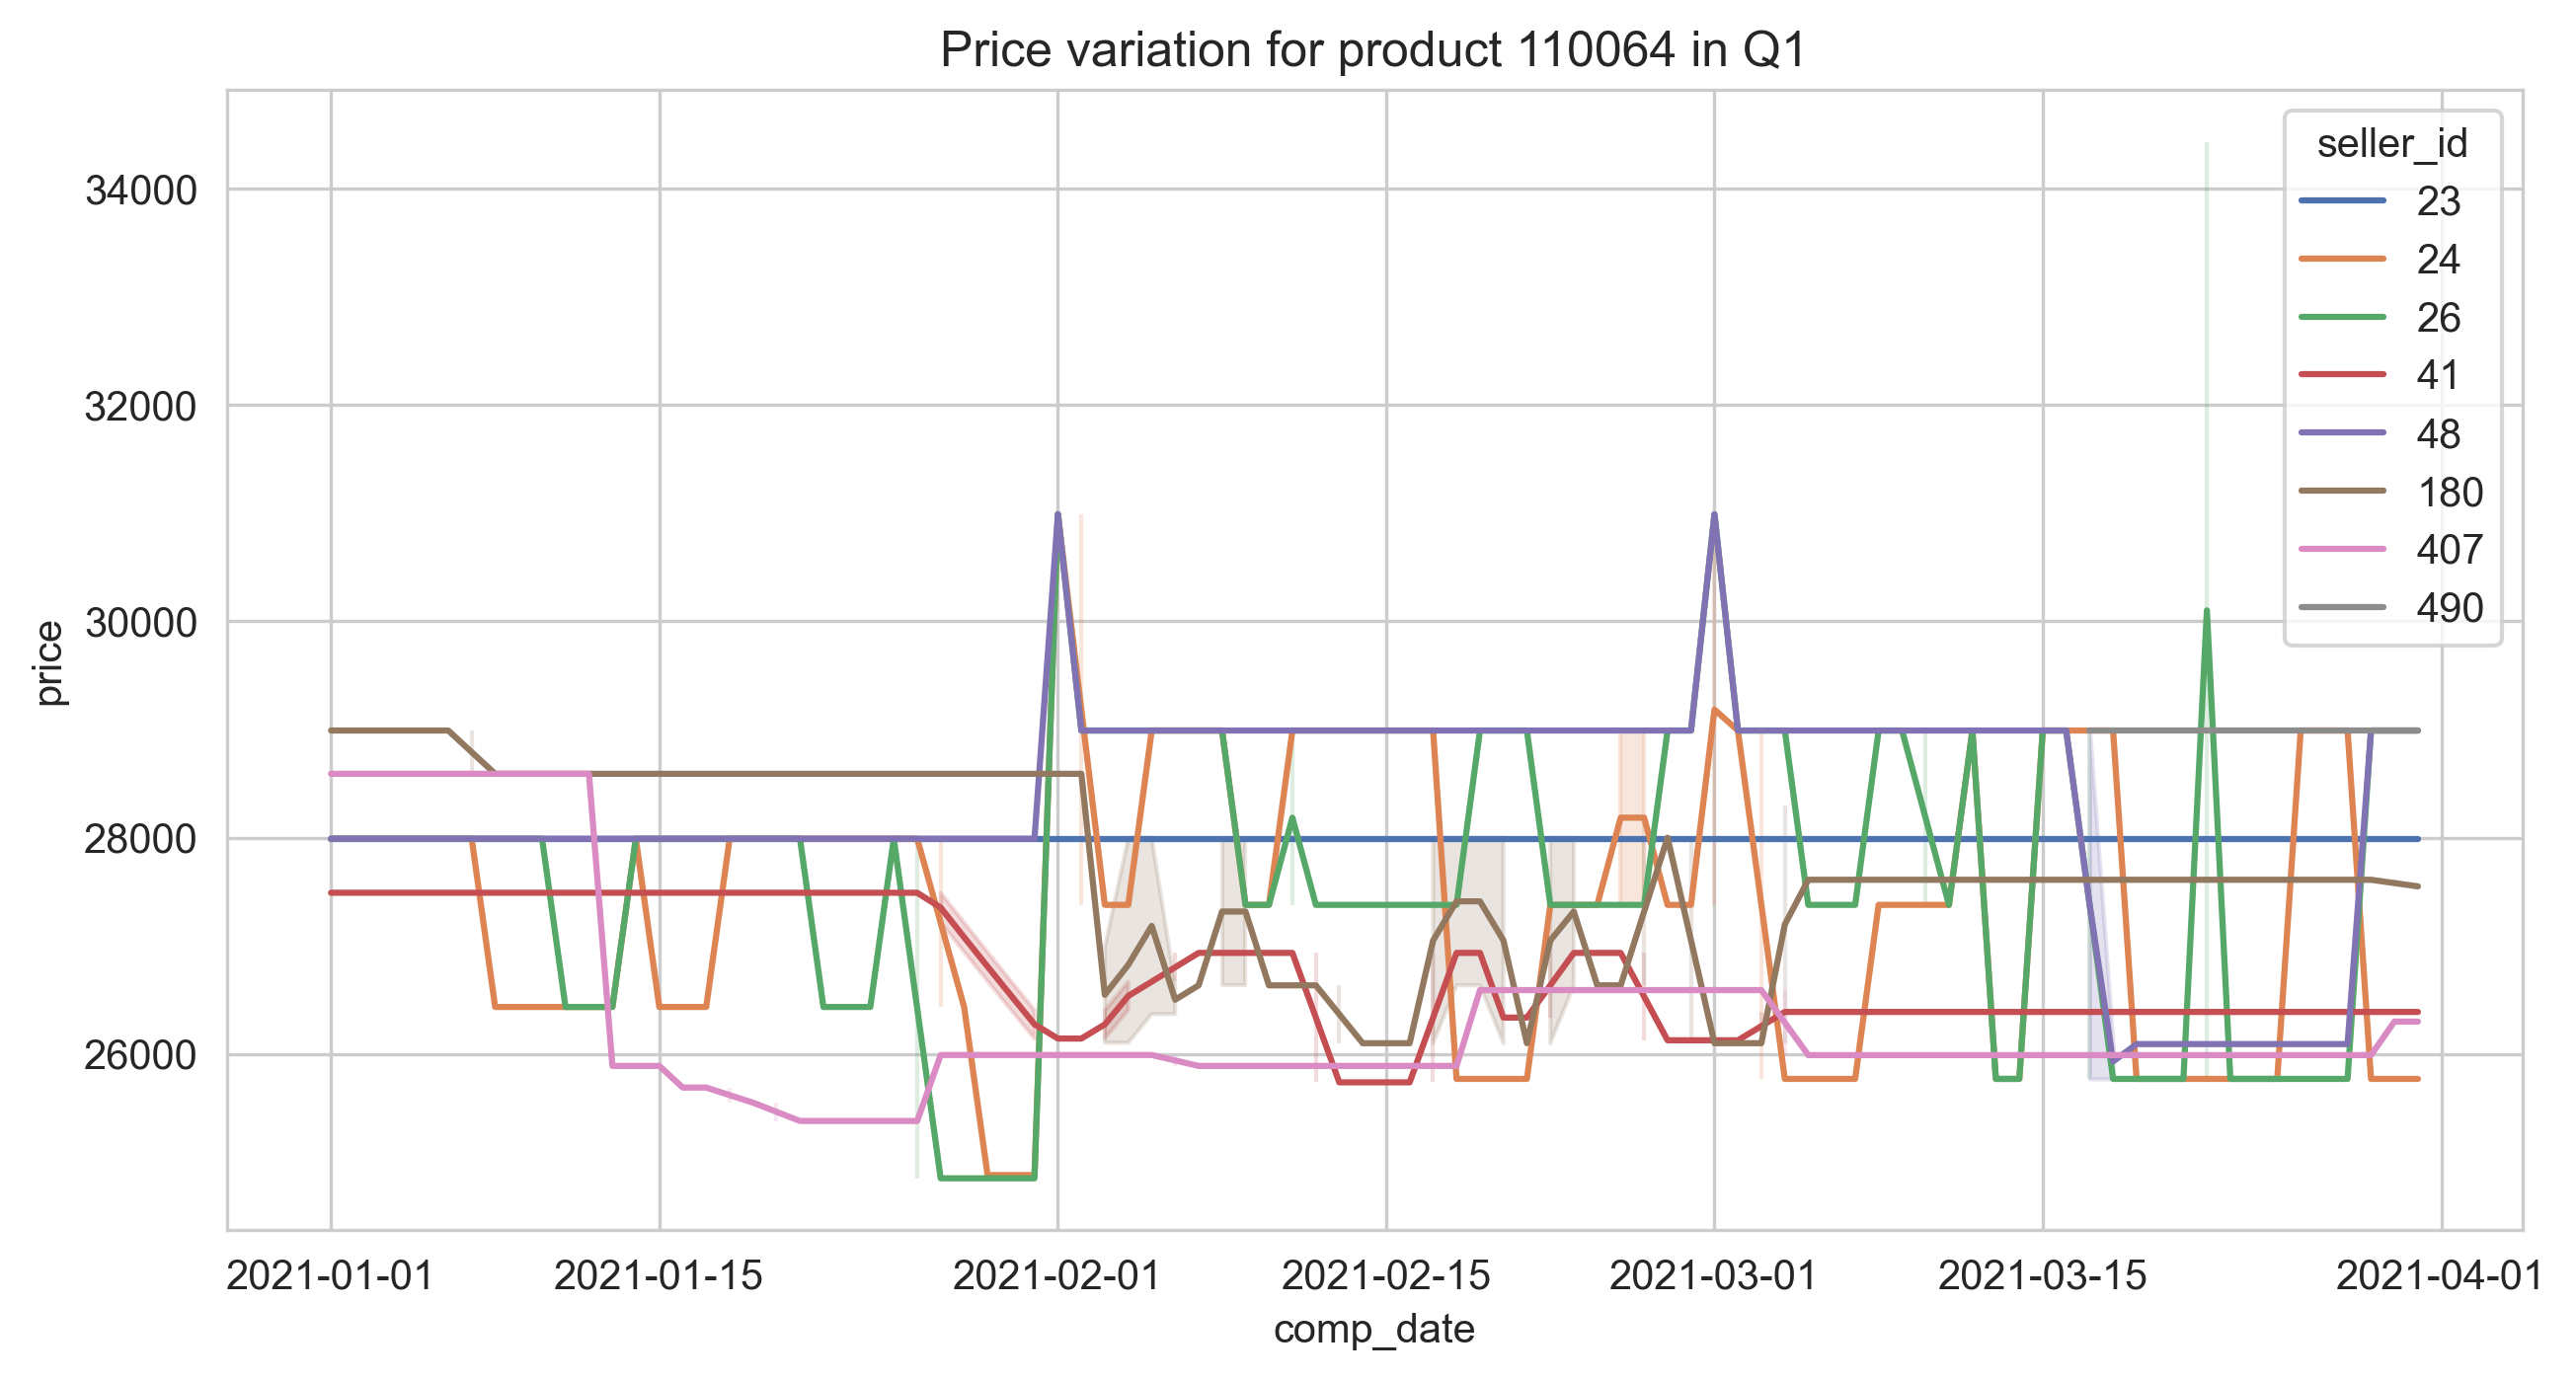

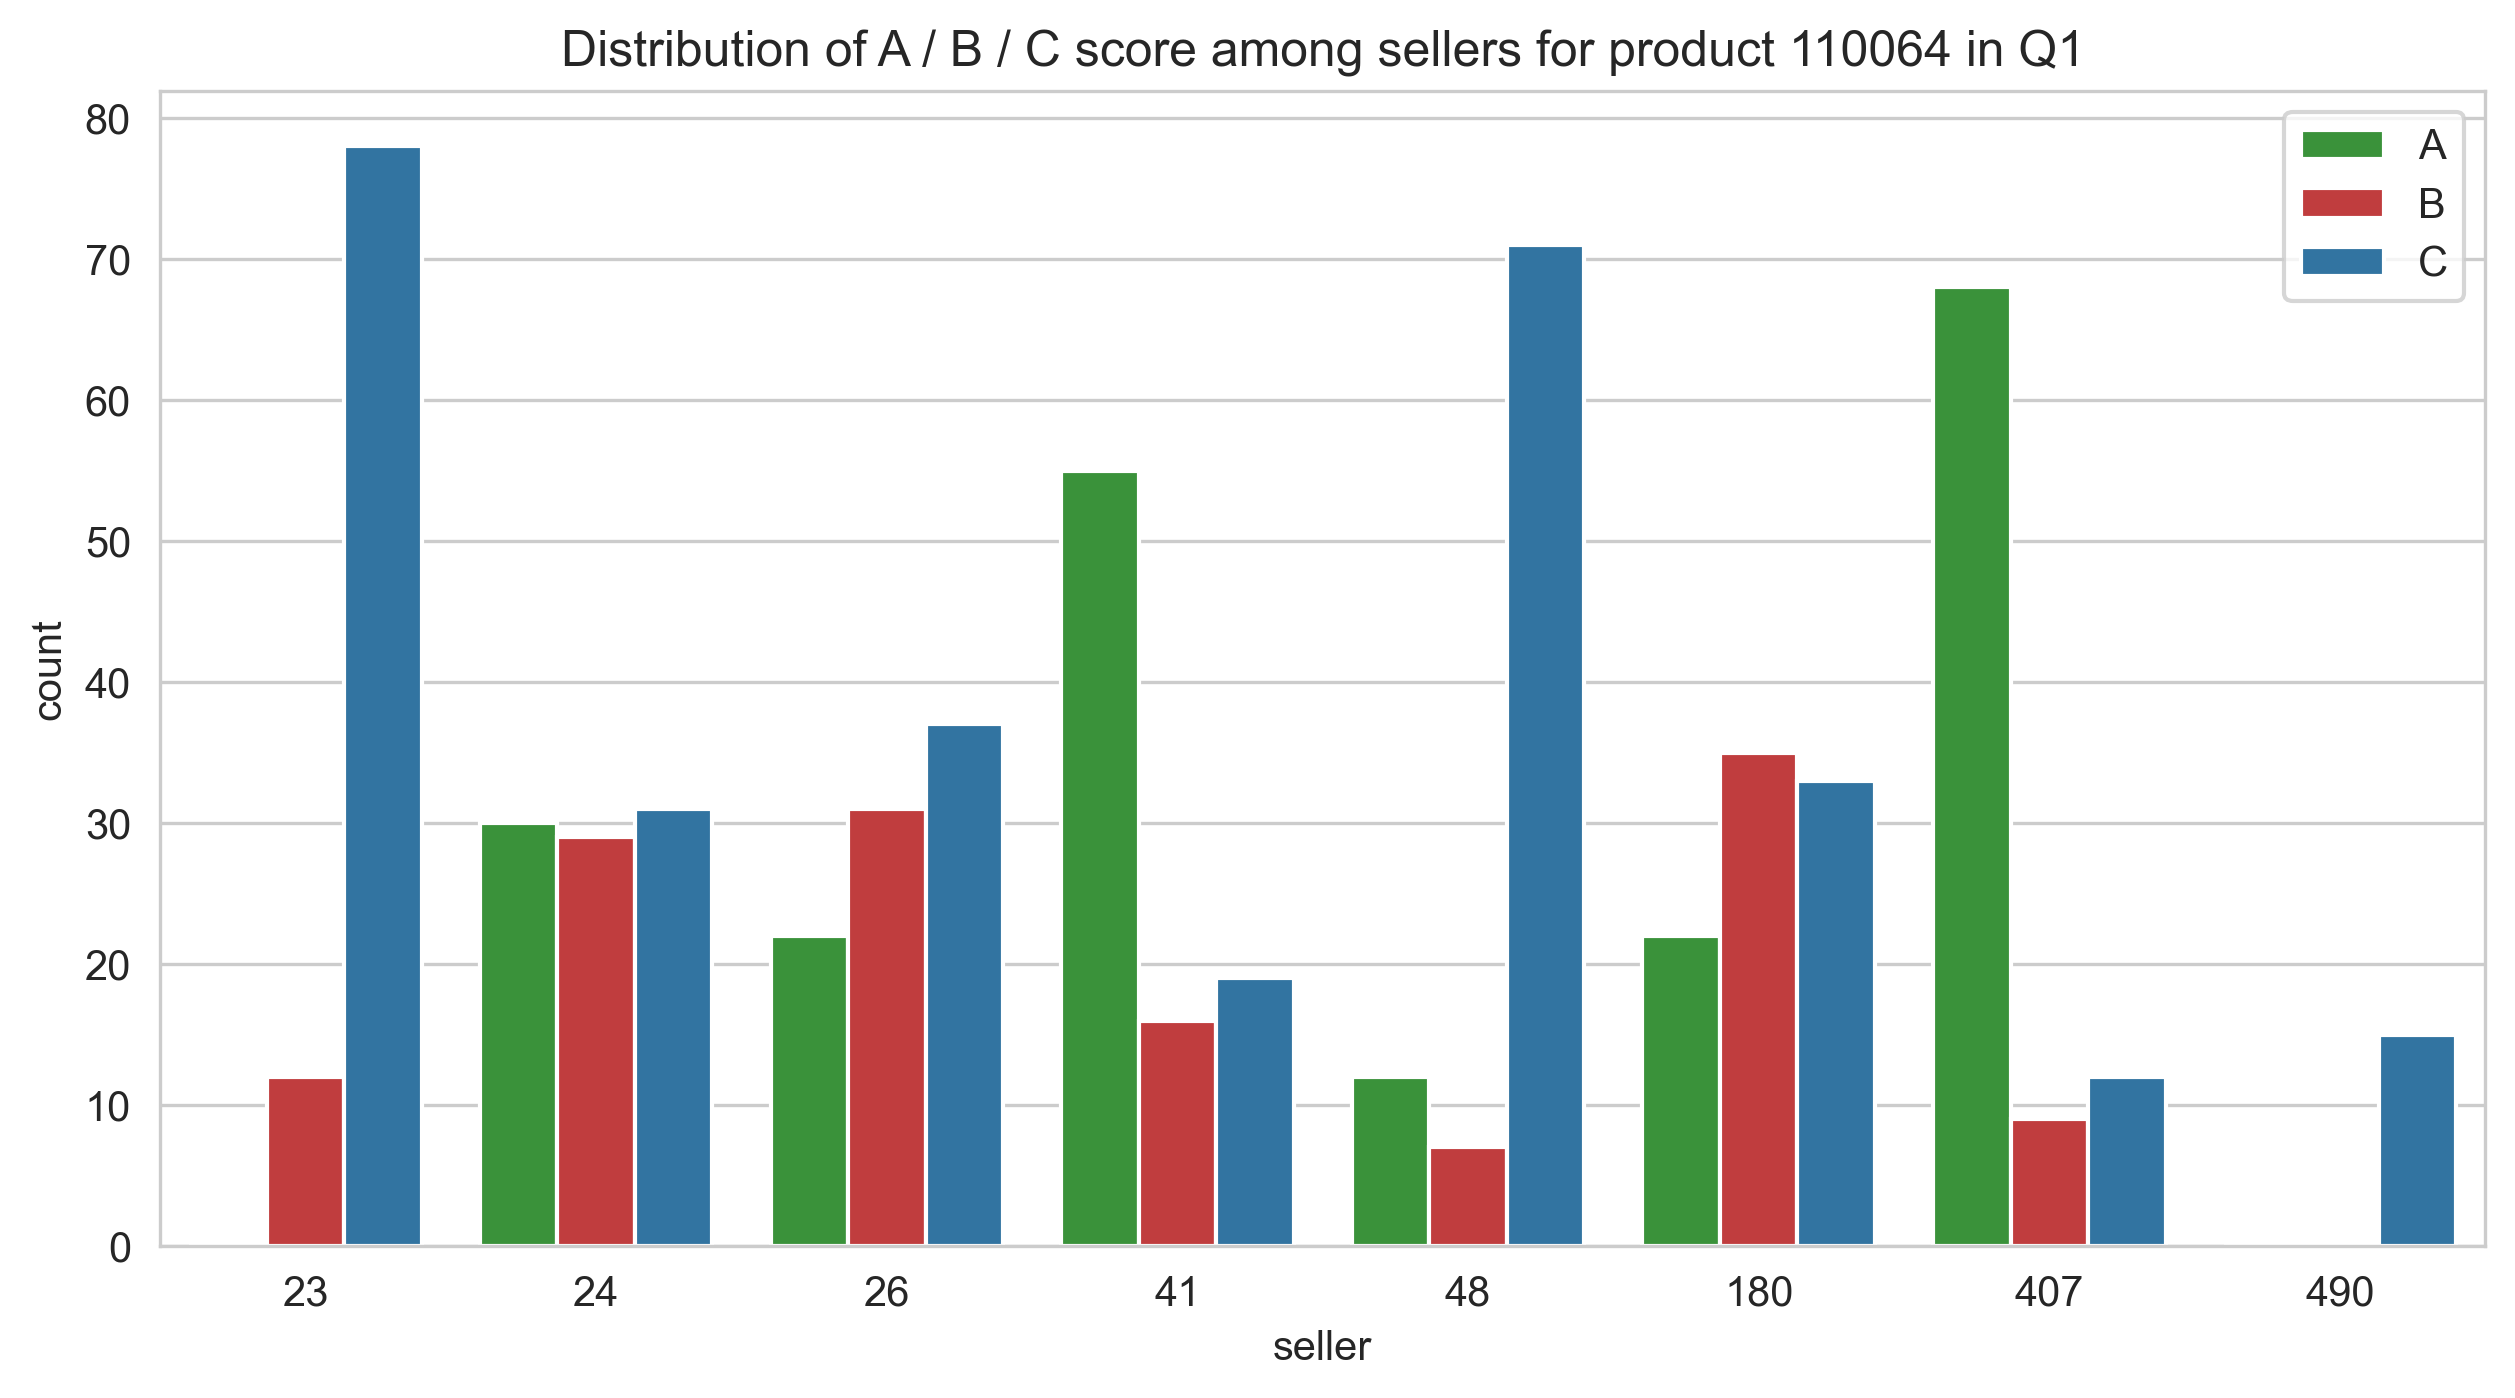

{23: [0.0, 0.13333333333333333, 0.8666666666666667], 24: [0.3333333333333333, 0.32222222222222224, 0.34444444444444444], 26: [0.24444444444444444, 0.34444444444444444, 0.4111111111111111], 41: [0.6111111111111112, 0.17777777777777778, 0.2111111111111111, 'COULDBEFOLLOWER'], 48: [0.13333333333333333, 0.07777777777777778, 0.7888888888888889], 180: [0.24444444444444444, 0.3888888888888889, 0.36666666666666664], 407: [0.7640449438202247, 0.10112359550561797, 0.1348314606741573, 'COULDBEFOLLOWER'], 490: [0.0, 0.0, 1.0]}


In [4]:
# Detect the relationship between each seller's price for a given product every day, and the min price of the other's sellers.
# The higher the difference, the bigger the chance to get an A -> "FOLLOWER"
# More A you have, the bigger the change to be considered a follower or a seller which has a lowest price strategy

def follower_detection(product_id, quarter):

    # Filter the dataset
    df_1 = df[(df.product_id == product_id) & (df.quarter == quarter)]

    # Dataviz
    plt.figure(figsize=(10, 5), dpi = 300)
    sns.set_style("whitegrid")
    sns.lineplot(df_1, x = 'comp_date',y = 'price', hue = 'seller_id', palette = 'deep')\
                    .set(title='Price variation for product {} in Q{}'.format(product_id, quarter))

    dataf = pd.DataFrame()

    windows = {1: 'daily'
#               , 2: 'bidaily'
#               , 3: 'tridaily'
#               , 7: 'weekly'
#               , 15: 'biweekly'
#               , 30: 'monthly'
               }

    # For each day:
    for day in df_1['enc_comp_date'].unique():

        # Make a copy and filter by day
        df_2 = df_1.copy(deep = True)
        df_2 = df_2[df_2['enc_comp_date'] == day]

        # For each seller
        for seller in df_2['seller_id'].unique():

            # Extract the price for a given seller and a given day
            price = df_2.loc[df['seller_id'] == seller, 'price'].iloc[0]

            # Take the min price excluded itself
            price_others_max = df_2.loc[df['seller_id'] != seller, 'price'].min()

            # Calculate the difference between prices
            difference = (price - price_others_max) / price * 100

            # Create a list with the day, seller and difference
            lst = [day, seller, difference]

            dataf = pd.concat([dataf, pd.DataFrame([lst])])

    dataf.rename(columns = {0: 'day', 1: 'seller', 2: 'difference'}, inplace = True)

    # For each window size, cut the dataset every day, every two days, every week etc...
    dfs = []
    for window in windows:
      L = [g for k, g in dataf.groupby('day')]
      dfs.extend([pd.concat(L[i:i+window]) for i in range(0, len(L)-window+1)])


    # Calculate the label on each dataset which are cut: A = leader, B = competitor, C = loser
    for i in range(len(dfs)):
        dfs[i]['label'] = pd.cut(dfs[i]['difference'], 3, labels = ['A', 'B', 'C'])

    # Create a dataframe which contains the occurrences of all the dataset created above, per seller, per label ABC
    data_frame = pd.DataFrame()
    for i in range(len(dfs)):
        data_frame = pd.concat([data_frame, dfs[i].drop(['day', 'difference'], axis = 1)])

    data_frame = data_frame.groupby(by = ['seller', 'label']).size().reset_index()
    data_frame.rename(columns = {0 : 'count'}, inplace = True)

    # Plot the distribution
    plt.figure(figsize=(10, 5), dpi = 300)
    ax = plt.gca()
    sns.barplot(data = data_frame, x = 'seller', y = 'count', hue = 'label', palette = ['tab:green', 'tab:red', 'tab:blue'], hue_order=['A', 'B', 'C'])\
                    .set(title='Distribution of A / B / C score among sellers for product {} in Q{}'.format(product_id, quarter))
    plt.legend()
    plt.show()

    # For each unique seller in the dataframe:
    storage = dict()

    # Calculate the percentage distribution of ABC
    for seller in data_frame.seller.unique():
        storage[seller] = data_frame.loc[data_frame['seller'] == seller, 'count'].tolist()

    # Set some rules to detect the follower. If A > 55% then "COULD BE FOLLOWER"
    for i in storage:
        total = sum(storage[i])
        for j in range(len(storage[i])):
            storage[i][j] = storage [i][j] / total
        if storage[i][0] > 0.55:
            storage[i].append('COULDBEFOLLOWER')

    print(storage)

follower_detection(110064, 1)

In [4]:
def pivot(product_id, quarter):
    df_1 = df[(df.product_id == product_id) & (df.quarter == quarter)]
    table = pd.pivot_table(df_1, values='price', index=['comp_date'], columns=['seller_id'])
    table.fillna(method='ffill', inplace=True)
    return table

dfp = pivot(110064, 1)

dict_dataframe = dict()
for col_1 in dfp.columns:
    dataframe_temp = pd.DataFrame()
    for col_2 in dfp.columns:
        if col_1 != col_2:
            series = pd.Series(dfp[col_1] - dfp[col_2], name = col_2)
            dataframe_temp = pd.concat([dataframe_temp, series], axis = 1)
            dict_dataframe[col_1] = dataframe_temp

dizionario = dict()
for i in dict_dataframe:
    diz_temp = dict()
    for j in dict_dataframe[i]:
        diz_temp[j] = dict_dataframe[i][j].std() / dfp[i].mean()
    dizionario[i] = diz_temp

del(dict_dataframe)

d = pd.DataFrame(0, index=list(dizionario.keys()), columns=list(dizionario.keys()))

for columns in d.columns:
    for x in dizionario:
        if columns != x:
            for y in dizionario[x]:
                d.loc[y, x] = dizionario[x][y]

dizionario_a_b = dict()

for i in range(3, 7, 1):
    d_copy = d.copy(deep = True)
    for col in d.columns:
        d_copy[col] = np.where(d_copy[col] > i/100, 'A', 'B')
    dizionario_a_b[i] = d_copy

dizionario_a_b

{3:     23  24  26  41  48  180 407 490
 23    B   A   A   B   A   A   A   B
 24    A   B   A   A   A   A   A   A
 26    A   A   B   A   A   A   A   A
 41    B   A   A   B   A   B   A   B
 48    A   A   A   A   B   A   A   A
 180   A   A   A   B   A   B   A   B
 407   A   A   A   A   A   A   B   B
 490   B   A   A   B   A   B   B   B,
 4:     23  24  26  41  48  180 407 490
 23    B   A   A   B   B   B   B   B
 24    A   B   A   A   A   A   A   A
 26    A   A   B   A   B   A   A   A
 41    B   A   A   B   A   B   B   B
 48    B   A   B   A   B   A   A   A
 180   B   A   A   B   A   B   B   B
 407   B   A   A   B   A   B   B   B
 490   B   A   A   B   A   B   B   B,
 5:     23  24  26  41  48  180 407 490
 23    B   B   B   B   B   B   B   B
 24    B   B   A   A   A   A   A   A
 26    B   A   B   A   B   A   A   A
 41    B   A   A   B   B   B   B   B
 48    B   A   B   B   B   A   A   B
 180   B   A   A   B   A   B   B   B
 407   B   A   A   B   B   B   B   B
 490   B   A   A   B   B   